In [7]:
from npc_sessions import DynamicRoutingSession, get_sessions, utils
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import os

In [8]:
def get_performance_by_block(session):

    trials=session.trials.to_dataframe()

    #loop through blocks

    task_performance_by_block={
        'context':[],
        'cross_modal_dprime':[],
        'signed_cross_modal_dprime':[],
        'vis_intra_dprime':[],
        'aud_intra_dprime':[],
    }

    for block in trials['block_index'].unique():

        block_trials=trials[trials['block_index']==block]

        vis_target_resp=(block_trials.query(
            'is_vis_target==True and \
            is_repeat==False'
        )['is_response']==True).mean()

        vis_nontarget_resp=(block_trials.query(
            'is_vis_nontarget==True and \
            is_repeat==False'
        )['is_response']==True).mean()

        aud_target_resp=(block_trials.query(
            'is_aud_target==True and \
            is_repeat==False'
        )['is_response']==True).mean()

        aud_nontarget_resp=(block_trials.query(
            'is_aud_nontarget==True and \
            is_repeat==False'
        )['is_response']==True).mean()
        
        if vis_target_resp==1:
            vis_target_resp=0.99
        elif vis_target_resp==0:
            vis_target_resp=0.01      
        if vis_nontarget_resp==1:
            vis_nontarget_resp=0.99
        elif vis_nontarget_resp==0:
            vis_nontarget_resp=0.01
        if aud_target_resp==1:
            aud_target_resp=0.99
        elif aud_target_resp==0:
            aud_target_resp=0.01
        if aud_nontarget_resp==1:
            aud_nontarget_resp=0.99
        elif aud_nontarget_resp==0:
            aud_nontarget_resp=0.01

        if block_trials['is_vis_context'].iloc[0]==True:
            cross_dprime=(st.norm.ppf(vis_target_resp) - st.norm.ppf(aud_target_resp))
            signed_cross_dprime=(st.norm.ppf(vis_target_resp) - st.norm.ppf(aud_target_resp))
            task_performance_by_block['context'].append('vis')

        elif block_trials['is_aud_context'].iloc[0]==True:
            cross_dprime=(st.norm.ppf(aud_target_resp) - st.norm.ppf(vis_target_resp))
            signed_cross_dprime=-(st.norm.ppf(aud_target_resp) - st.norm.ppf(vis_target_resp))
            task_performance_by_block['context'].append('aud')
        
        vis_dprime=(st.norm.ppf(vis_target_resp) - st.norm.ppf(vis_nontarget_resp))
        aud_dprime=(st.norm.ppf(aud_target_resp) - st.norm.ppf(aud_nontarget_resp))

        task_performance_by_block['cross_modal_dprime'].append(cross_dprime)
        task_performance_by_block['signed_cross_modal_dprime'].append(signed_cross_dprime)

        task_performance_by_block['vis_intra_dprime'].append(vis_dprime)
        task_performance_by_block['aud_intra_dprime'].append(aud_dprime)
            
    return pd.DataFrame.from_dict(task_performance_by_block)

def plot_performance_by_block(session, task_performance_by_block_df):

    trials=session.trials.to_dataframe()

    n_passing_blocks=np.sum(task_performance_by_block_df['cross_modal_dprime']>=1.5)
    failed_block_ind=task_performance_by_block_df['cross_modal_dprime']<1.5

    #blockwise behavioral performance
    xvect=task_performance_by_block_df.index.values
    fig,ax=plt.subplots(2,1)
    ax[0].plot(xvect,task_performance_by_block_df['signed_cross_modal_dprime'],'ko-',label='cross-modal')
    ax[0].plot(xvect[failed_block_ind],task_performance_by_block_df['signed_cross_modal_dprime'][failed_block_ind],'ro',label='failed')
    ax[0].axhline(0,color='k',linestyle='--',linewidth=0.5)
    ax[0].set_title('cross-modal dprime: '+str(n_passing_blocks)+'/'+str(len(task_performance_by_block_df))+' blocks passed')
    ax[0].set_ylabel('aud <- dprime -> vis')

    ax[1].plot(xvect,task_performance_by_block_df['vis_intra_dprime'],'go-',label='vis')
    ax[1].plot(xvect,task_performance_by_block_df['aud_intra_dprime'],'bo-',label='aud')
    ax[1].set_title('intra-modal dprime')
    ax[1].legend(['vis','aud'])
    ax[1].set_xlabel('block index')
    ax[1].set_ylabel('dprime')

    fig.suptitle(session.id)
    fig.tight_layout()

    return fig

def plot_first_lick_latency_hist(session):
    #first lick latency histogram

    trials=session.trials.to_dataframe()

    xbins=np.arange(0,1,0.05)
    fig,ax=plt.subplots(1,1)
    ax.hist(trials.query('is_vis_stim==True')['response_time']-
            trials.query('is_vis_stim==True')['stim_start_time'],
            bins=xbins,alpha=0.5)

    ax.hist(trials.query('is_aud_stim==True')['response_time']-
            trials.query('is_aud_stim==True')['stim_start_time'],
            bins=xbins,alpha=0.5)

    ax.legend(['vis stim','aud stim'])
    ax.set_xlabel('lick latency (s)')
    ax.set_ylabel('trial count')
    ax.set_title('lick latency: '+session.id)

    return fig

def plot_lick_raster(session):

    lick_times=utils.get_sync_data(session.sync_data).get_rising_edges(
            "lick_sensor", units="seconds"
        )
    trials=session.trials.to_dataframe()

    fig,ax=plt.subplots(1,1)
    ax.axvline(0,color='k',linestyle='--',linewidth=0.5)
    for tt,trial in trials.iterrows():

        trial_licks = lick_times[
            (lick_times>trial['stim_start_time']-1) & 
            (lick_times<trial['stim_start_time']+2)
            ]-trial['stim_start_time']
        
        ax.vlines(trial_licks,tt,tt+1)

    ax.set_xlim([-1,2])
    ax.set_xlabel('time rel to stim onset (s)')
    ax.set_ylabel('trial number')
    ax.set_title('lick raster: '+session.id)

    return fig


In [10]:
session = DynamicRoutingSession('668755_2023-08-31')

In [ ]:
task_performance_by_block = get_performance_by_block(session)
fig=plot_performance_by_block(session, task_performance_by_block)


In [ ]:
fig=plot_first_lick_latency_hist(session)

In [ ]:
fig=plot_lick_raster(session)

NameError: name 'lick_times' is not defined

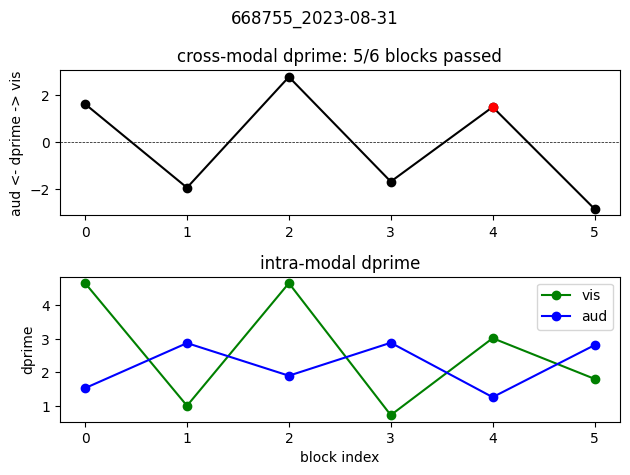

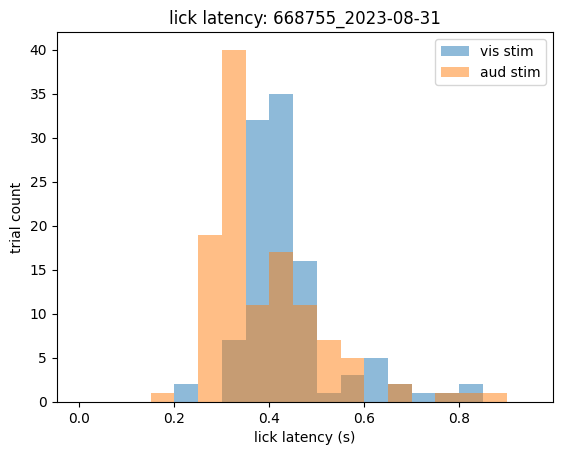

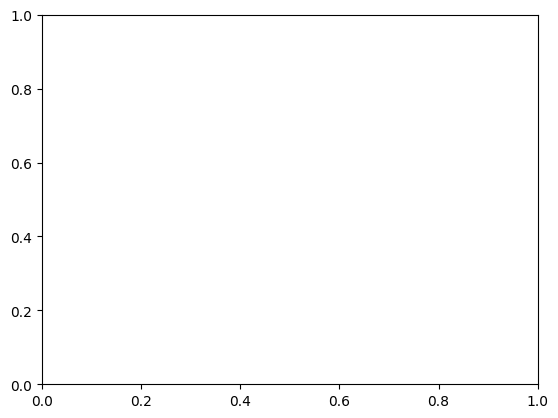

In [9]:
for session in get_sessions():
    # try:
        
    task_performance_by_block_df = get_performance_by_block(session)
    fig=plot_performance_by_block(session, task_performance_by_block_df)

    savepath=os.path.join(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR_QC_stuff\task_behavior",session.id+"_task_performance_by_block.png")
    fig.savefig(savepath, dpi=300, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None,
            )
    
    fig=plot_first_lick_latency_hist(session)

    savepath=os.path.join(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR_QC_stuff\task_behavior",session.id+"_first_lick_latency.png")
    fig.savefig(savepath, dpi=300, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None,
            )

    fig=plot_lick_raster(session)

    savepath=os.path.join(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR_QC_stuff\task_behavior",session.id+"_lick_raster.png")
    fig.savefig(savepath, dpi=300, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None,
            )

    # except:
    #     continue